# WaveFrontModel Testing Notebook

Load a trained WaveFrontModel from a checkpoint, run inference on test data, and visualize results.

In [13]:
%matplotlib inline

import sys
import os

# Ensure MPS fallback for Apple Silicon
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from data import collate_wavefront_batch, get_wavefront_datasets
from model import load_model
from testing.test_results import collect_samples, eval_model
from metrics import compute_metrics
from plotting import plot_ground_truth, plot_pred, plot_wave_pattern, plot_mse_error

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: mps


## 1. Configuration

Set the path to your checkpoint and grid parameters.

In [14]:
# --- Configuration ---
MODEL_PATH = "wavefront_model.pth"  # <-- set your checkpoint path here

# Grid parameters (should match training)
grid_config = {"nx": 50, "nt": 250, "dx": 0.02, "dt": 0.004}

# Test data parameters
N_SAMPLES = 50
BATCH_SIZE = 8
MAX_STEPS = 3      # max pieces in piecewise constant IC
ONLY_SHOCKS = False # include rarefactions too

## 2. Load Model

In [15]:
model = load_model(MODEL_PATH, device, {"model": "WaveFrontModel"})
model.eval()

n_params = sum(p.numel() for p in model.parameters())
print(f"Model loaded: {n_params:,} parameters")
print(f"  hidden_dim={model.hidden_dim}, rarefaction_angles={model.rarefaction_angles}")
print(f"  max_interaction_rounds={model.max_interaction_rounds}, sigma={model.sigma}")

Model loaded: 10,852 parameters
  hidden_dim=64, rarefaction_angles=5
  max_interaction_rounds=5, sigma=0.01


## 3. Generate Test Data

In [16]:
_, _, test_ds = get_wavefront_datasets(
    n_samples=N_SAMPLES,
    grid_config=grid_config,
    model_name="WaveFrontModel",
    train_ratio=0.0,
    val_ratio=0.0,
    max_steps=MAX_STEPS,
    only_shocks=ONLY_SHOCKS,
)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_wavefront_batch)
print(f"Test set: {len(test_ds)} samples, {len(test_loader)} batches")

  steps=2: using 25 cached samples
  steps=3: using 25 cached samples
Created datasets: train=0, val=0, test=50
Test set: 50 samples, 7 batches


## 4. Evaluate Metrics

In [17]:
metrics, samples = eval_model(model, test_loader, device, grid_config=grid_config, num_plots=4)

print("Test Metrics:")
print("-" * 40)
for k, v in metrics.items():
    print(f"  {k:12s}: {v:.6f}")
print("-" * 40)

Testing: 100%|██████████| 7/7 [00:00<00:00, 25.88it/s]

Test Metrics:
----------------------------------------
  mse         : 0.005365
  mae         : 0.041810
  rel_l2      : 0.132351
  max_error   : 0.539129
----------------------------------------


## 5. Visualize Predictions

### 5a. Ground Truth vs Prediction side by side

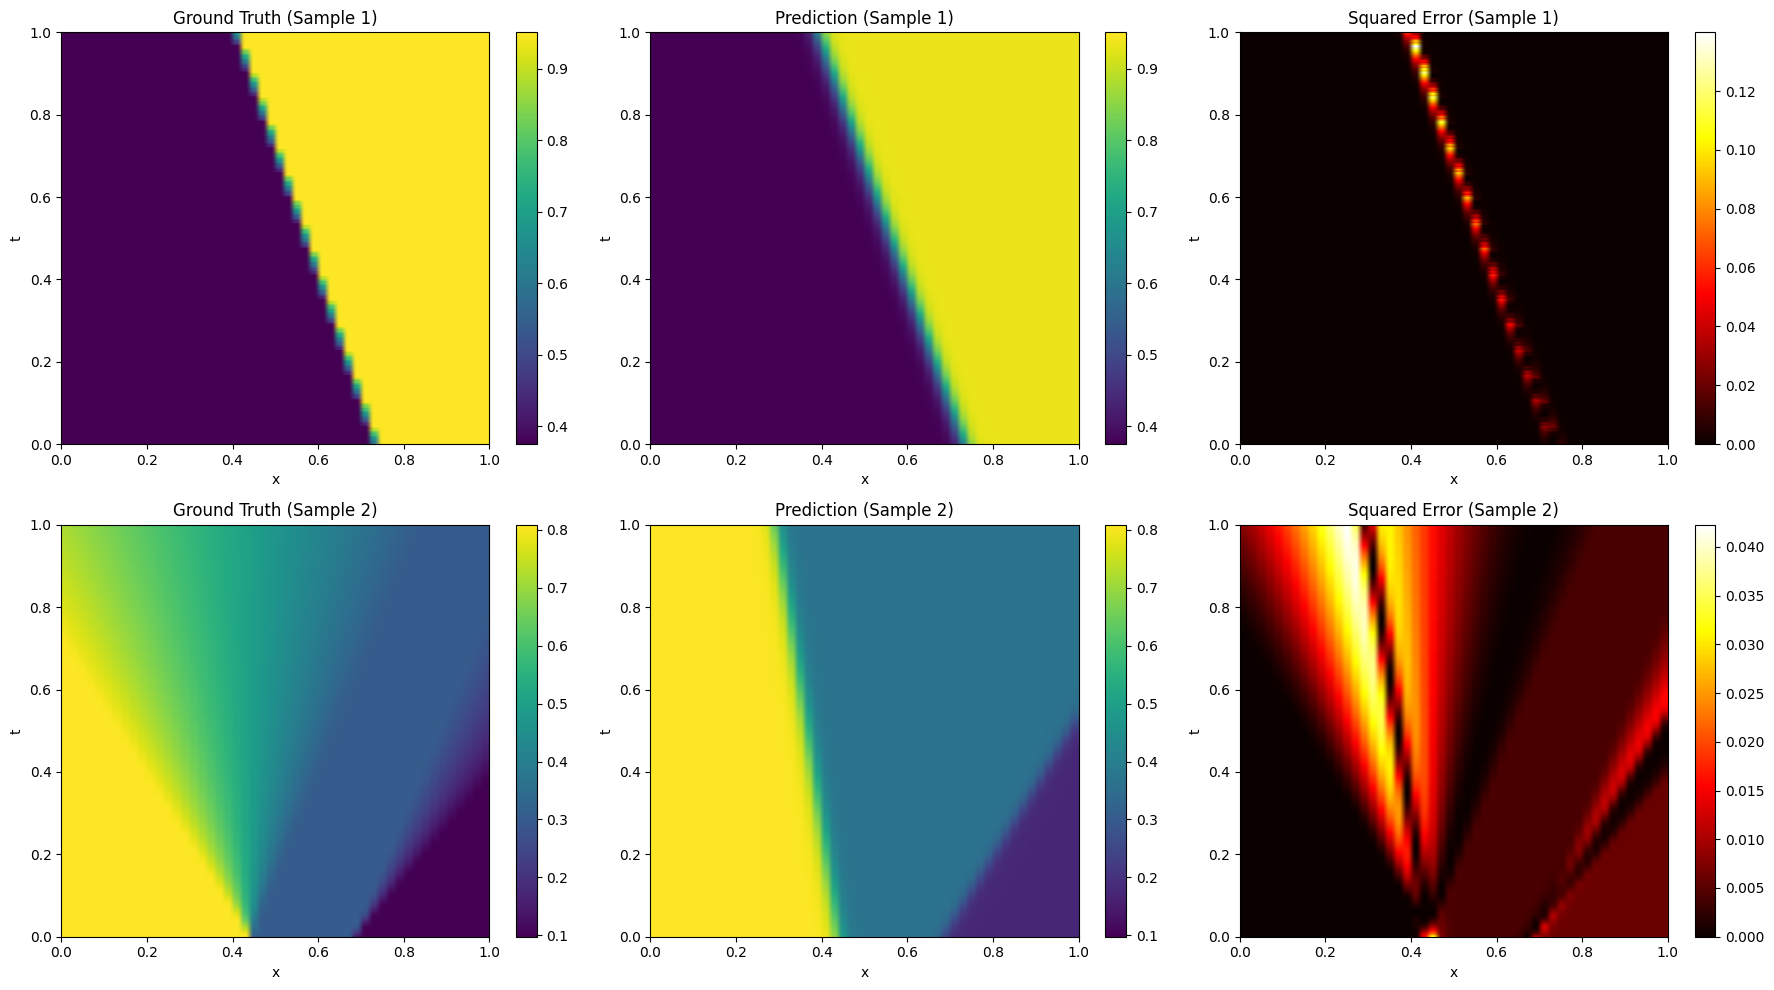

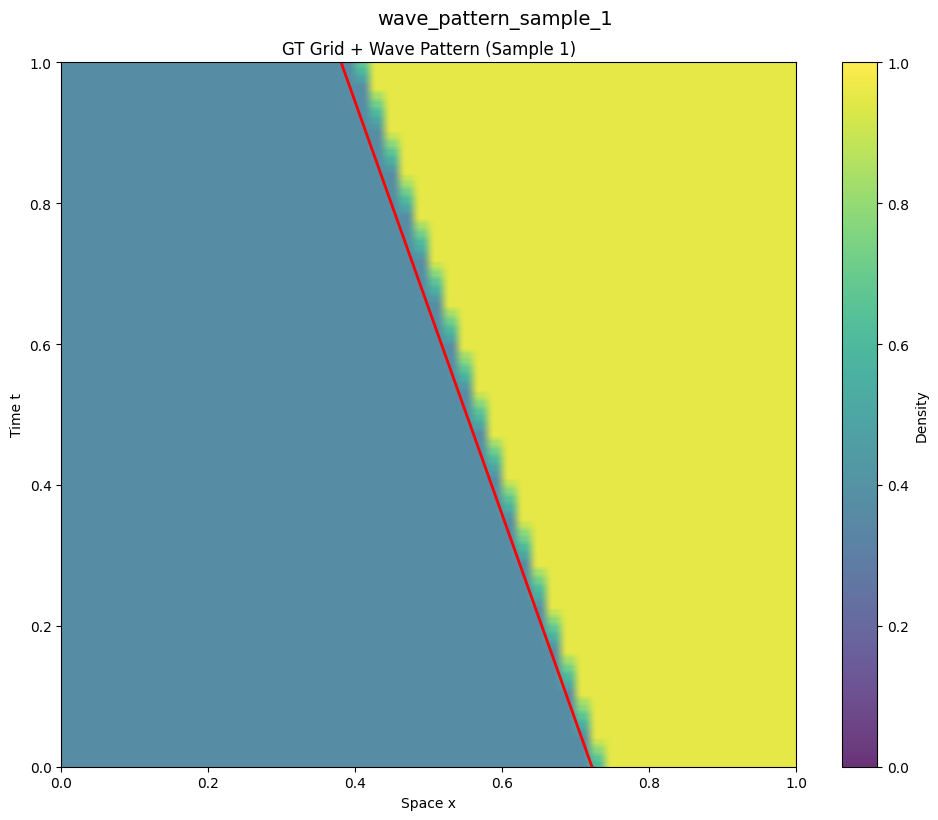

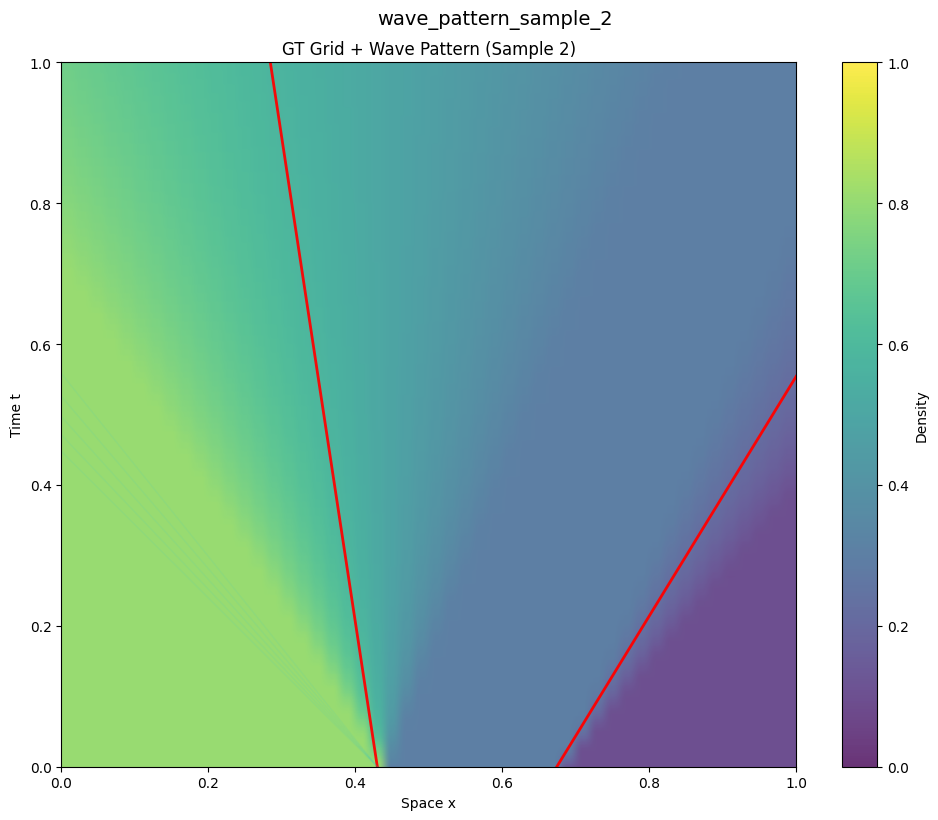

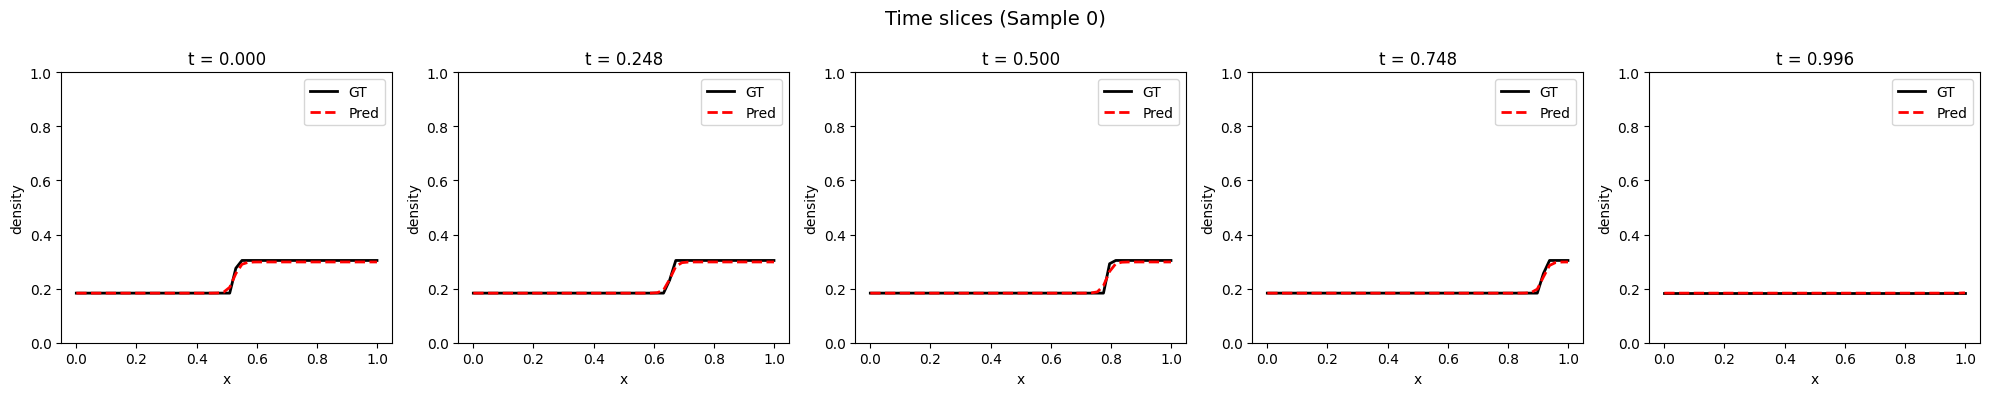

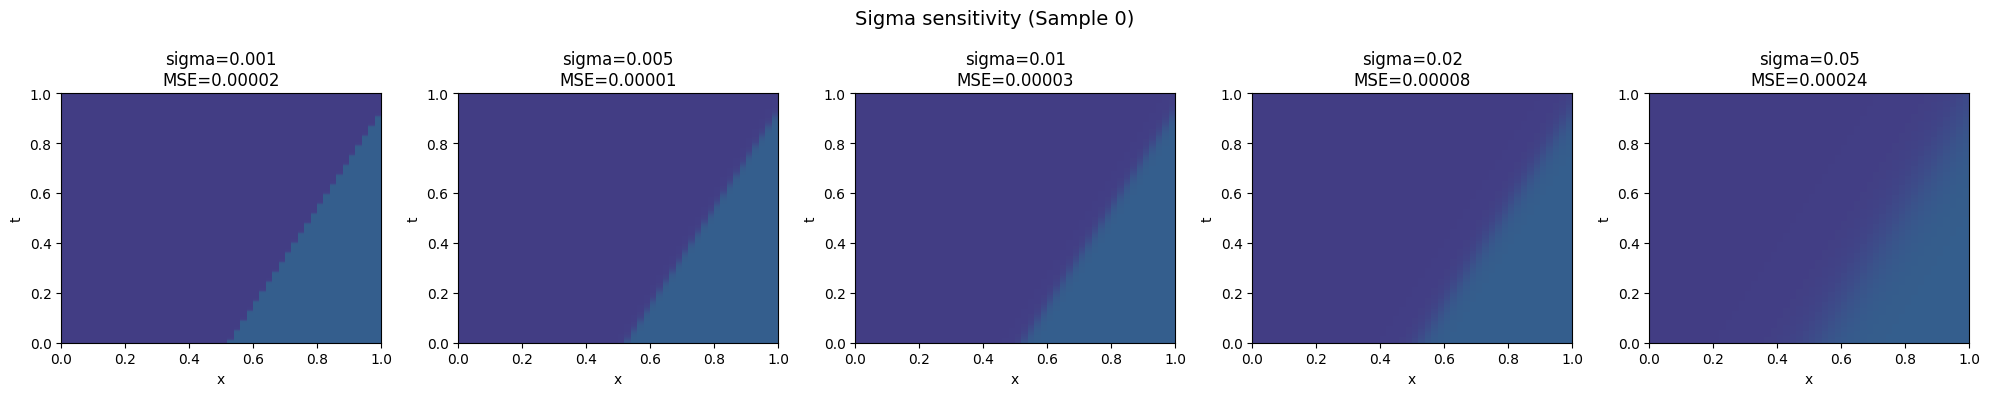

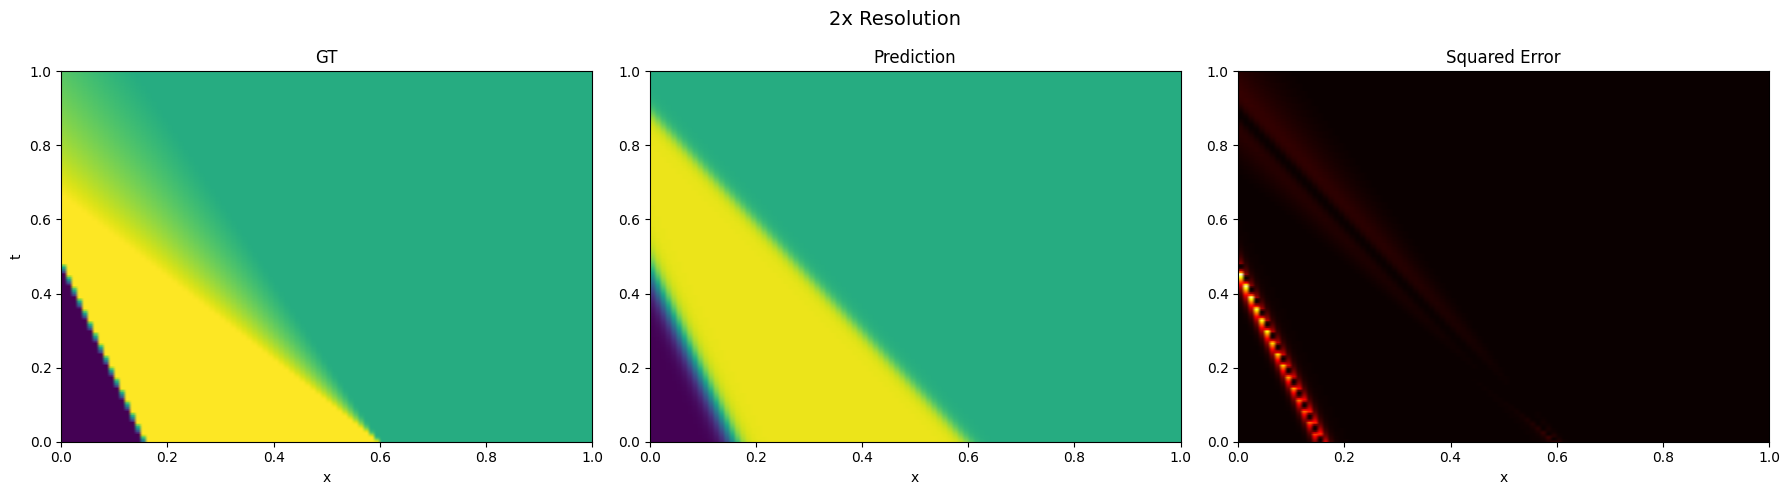

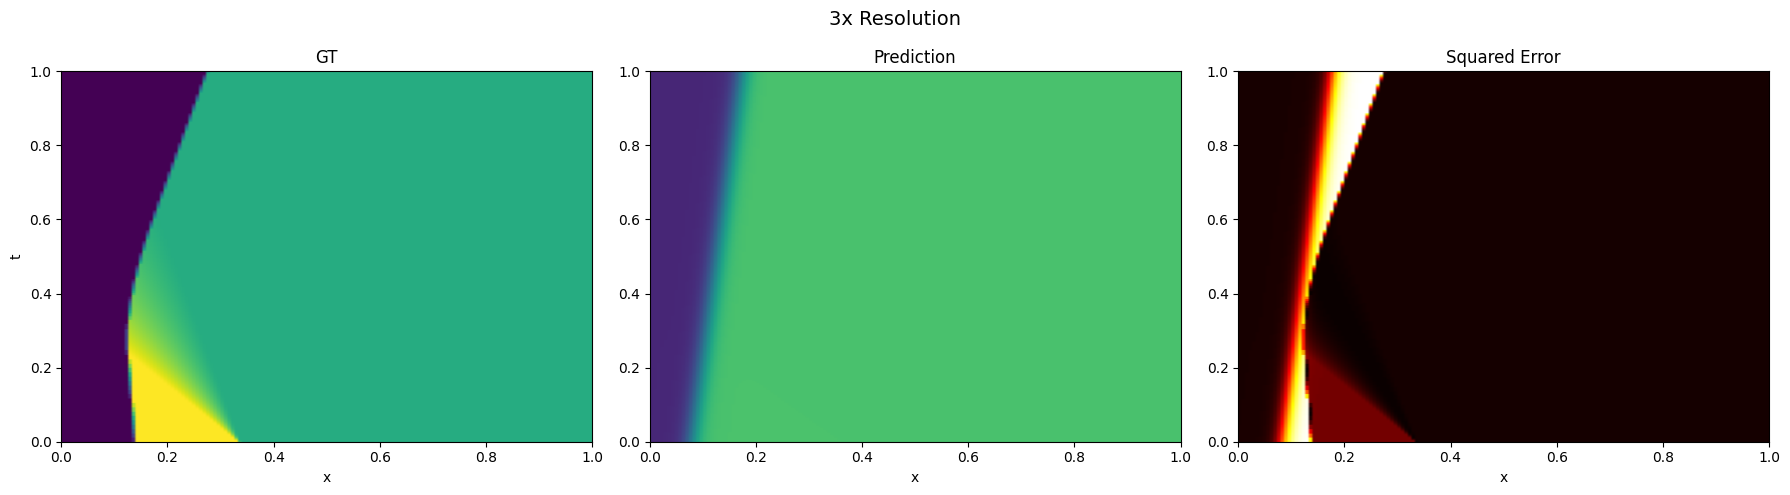

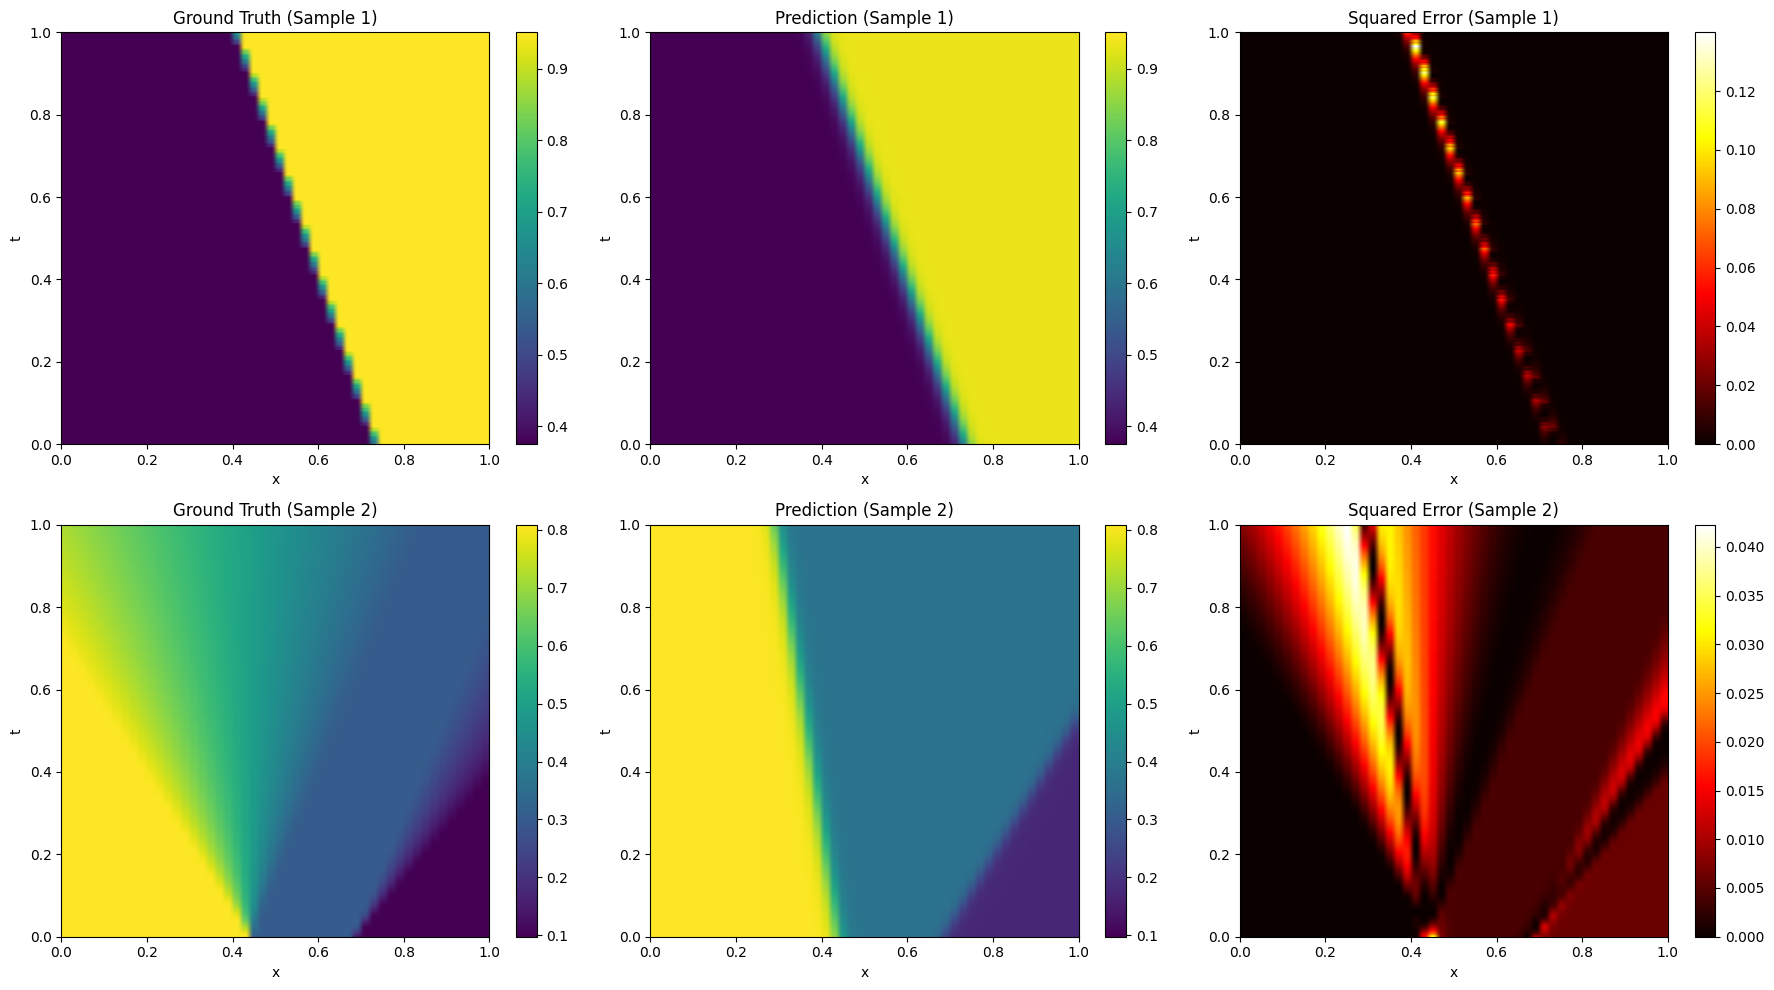

In [18]:
n_show = min(4, samples["grids"].shape[0])
extent = [0, grid_config["nx"] * grid_config["dx"], 0, grid_config["nt"] * grid_config["dt"]]

fig, axes = plt.subplots(n_show, 3, figsize=(18, 5 * n_show))
if n_show == 1:
    axes = axes[np.newaxis, :]

for i in range(n_show):
    gt = samples["grids"][i]
    pred = samples["output_grid"][i]
    error = (pred - gt) ** 2

    vmin = min(gt.min(), pred.min())
    vmax = max(gt.max(), pred.max())

    im0 = axes[i, 0].imshow(gt, extent=extent, aspect="auto", origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
    axes[i, 0].set_title(f"Ground Truth (Sample {i+1})")
    axes[i, 0].set_xlabel("x"); axes[i, 0].set_ylabel("t")
    plt.colorbar(im0, ax=axes[i, 0])

    im1 = axes[i, 1].imshow(pred, extent=extent, aspect="auto", origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
    axes[i, 1].set_title(f"Prediction (Sample {i+1})")
    axes[i, 1].set_xlabel("x"); axes[i, 1].set_ylabel("t")
    plt.colorbar(im1, ax=axes[i, 1])

    im2 = axes[i, 2].imshow(error, extent=extent, aspect="auto", origin="lower", cmap="hot")
    axes[i, 2].set_title(f"Squared Error (Sample {i+1})")
    axes[i, 2].set_xlabel("x"); axes[i, 2].set_ylabel("t")
    plt.colorbar(im2, ax=axes[i, 2])

plt.tight_layout()
plt.show()

### 5b. Wave Pattern Overlay

Shows predicted wave lines (shocks=red, rarefactions=blue, spawned=green) on top of the ground truth grid.

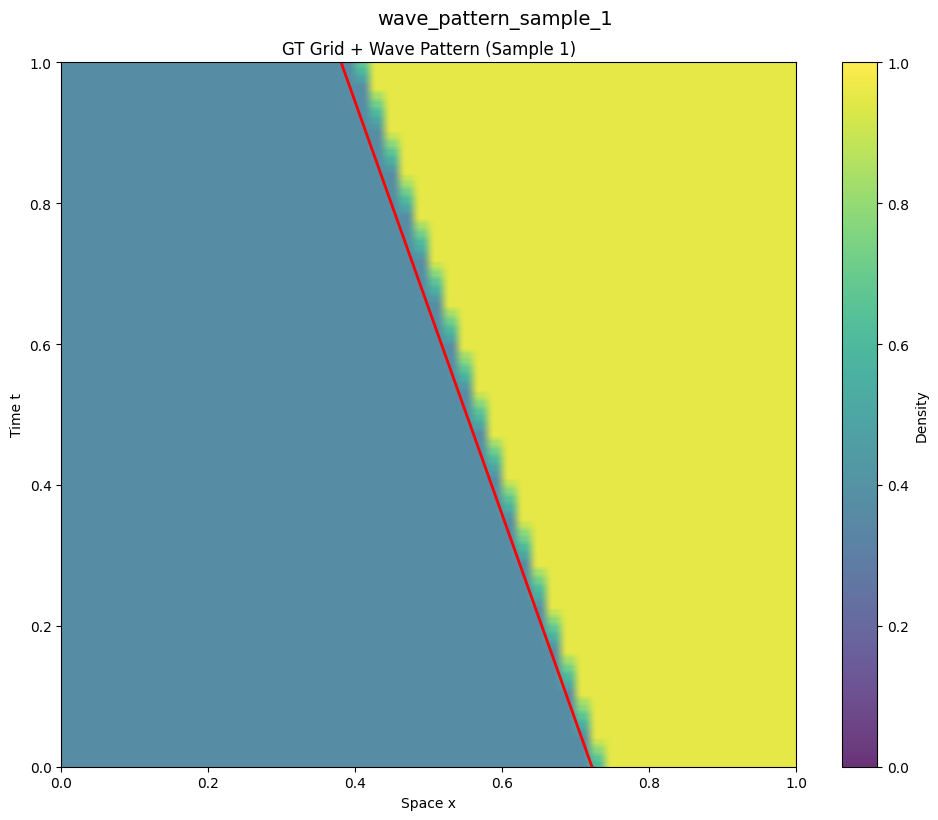

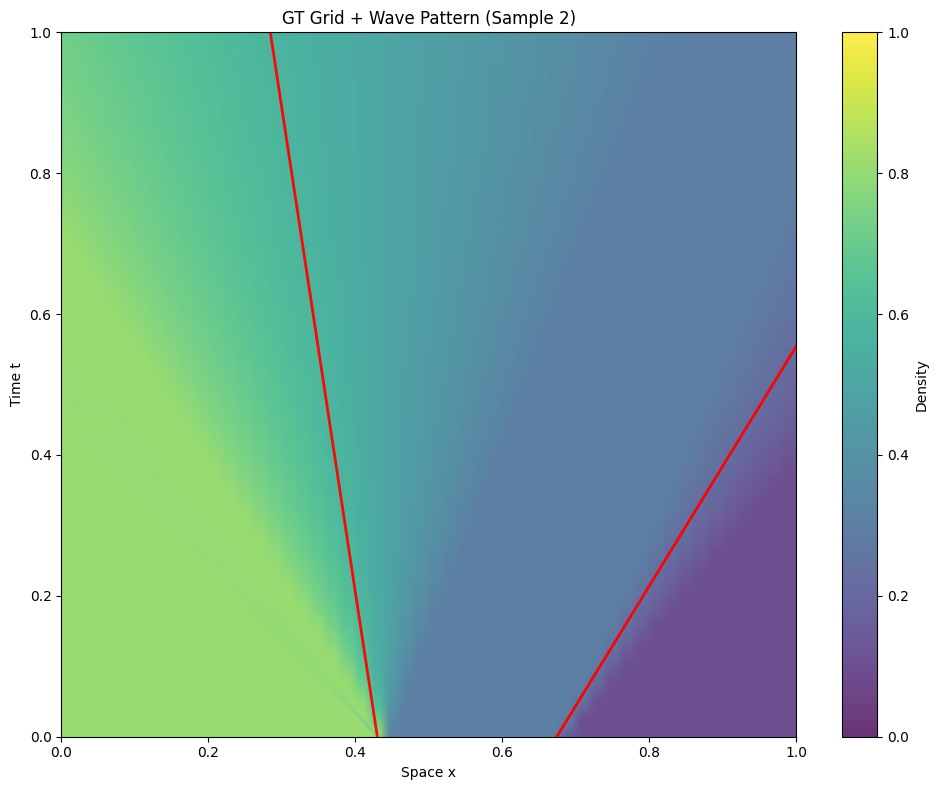

In [19]:
figures = plot_wave_pattern(samples, grid_config)
for key, fig in figures:
    fig.suptitle(key, fontsize=14, y=1.02)
    plt.show()

## 6. Single-Sample Deep Dive

Pick a specific sample and inspect the wave decomposition in detail.

In [20]:
SAMPLE_IDX = 0  # <-- change to inspect different samples

# Get one batch and run inference
batch_input, batch_target = next(iter(test_loader))
batch_input = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch_input.items()}
batch_target = batch_target.to(device)

with torch.no_grad():
    # Use build_waves + get_grid separately for inspection
    waves = model.build_waves(
        batch_input,
        rarefaction_angles=model.rarefaction_angles,
        max_interaction_rounds=model.max_interaction_rounds,
    )
    output_grid = model.get_grid(waves, batch_input["t_coords"], batch_input["x_coords"], model.sigma)

# Extract sample
s = SAMPLE_IDX
gt = batch_target[s, 0].cpu().numpy()
pred = output_grid[s, 0].cpu().numpy()

print(f"Sample {s}: {int(batch_input['disc_mask'][s].sum())} discontinuities")
print(f"  Base density: {waves['base_density'][s].item():.4f}")
print(f"  Total waves: {waves['wave_origin_x'].shape[1]}")
print(f"  Active waves: {int((waves['wave_active'][s] > 0.05).sum())}")

Sample 0: 1 discontinuities
  Base density: 0.1834
  Total waves: 60
  Active waves: 1


In [21]:
# Print wave details for this sample
active_mask = waves["wave_active"][s].cpu() > 0.05
wave_labels = {0: "shock", 1: "rarefaction", 2: "spawned"}

print(f"{'Type':>12s}  {'Origin x':>9s}  {'Origin t':>9s}  {'Speed':>8s}  {'Jump':>8s}  {'Activity':>8s}")
print("-" * 70)
for w in range(waves["wave_origin_x"].shape[1]):
    if not active_mask[w]:
        continue
    wtype = int(round(waves["wave_types"][s, w].item()))
    label = wave_labels.get(wtype, f"type={wtype}")
    ox = waves["wave_origin_x"][s, w].item()
    ot = waves["wave_origin_t"][s, w].item()
    sp = waves["wave_speeds"][s, w].item()
    jm = waves["wave_jumps"][s, w].item()
    ac = waves["wave_active"][s, w].item()
    print(f"{label:>12s}  {ox:9.4f}  {ot:9.4f}  {sp:8.4f}  {jm:8.4f}  {ac:8.4f}")

        Type   Origin x   Origin t     Speed      Jump  Activity
----------------------------------------------------------------------
       shock     0.5148     0.0000    0.5139    0.1180    0.9764


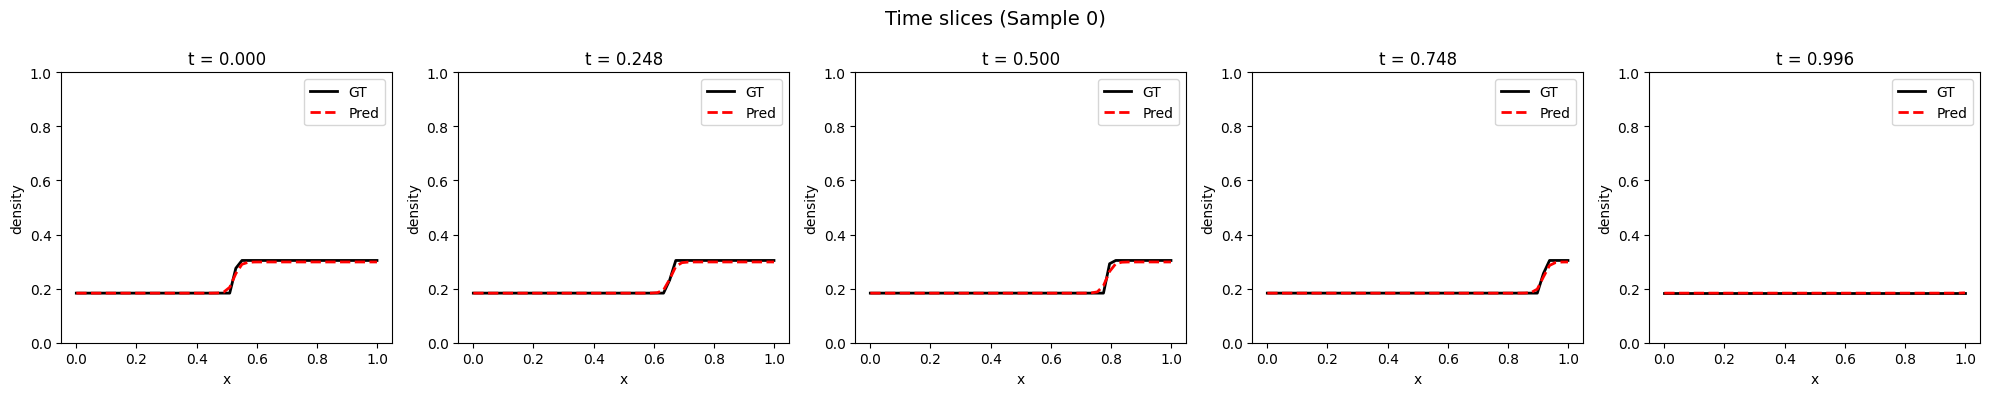

In [22]:
# Time-slice comparison at selected timesteps
T_max = grid_config["nt"] * grid_config["dt"]
X_max = grid_config["nx"] * grid_config["dx"]
x_axis = np.linspace(0, X_max, grid_config["nx"])

timesteps = [0, grid_config["nt"] // 4, grid_config["nt"] // 2, 3 * grid_config["nt"] // 4, grid_config["nt"] - 1]

fig, axes = plt.subplots(1, len(timesteps), figsize=(4 * len(timesteps), 4))
for ax, ti in zip(axes, timesteps):
    t_val = ti * grid_config["dt"]
    ax.plot(x_axis, gt[ti], "k-", label="GT", linewidth=2)
    ax.plot(x_axis, pred[ti], "r--", label="Pred", linewidth=2)
    ax.set_title(f"t = {t_val:.3f}")
    ax.set_xlabel("x")
    ax.set_ylabel("density")
    ax.legend()
    ax.set_ylim(0, 1)

plt.suptitle(f"Time slices (Sample {s})", fontsize=14)
plt.tight_layout()
plt.show()

## 7. Hyperparameter Sensitivity

Test how `sigma` (sigmoid sharpness) affects the reconstruction.

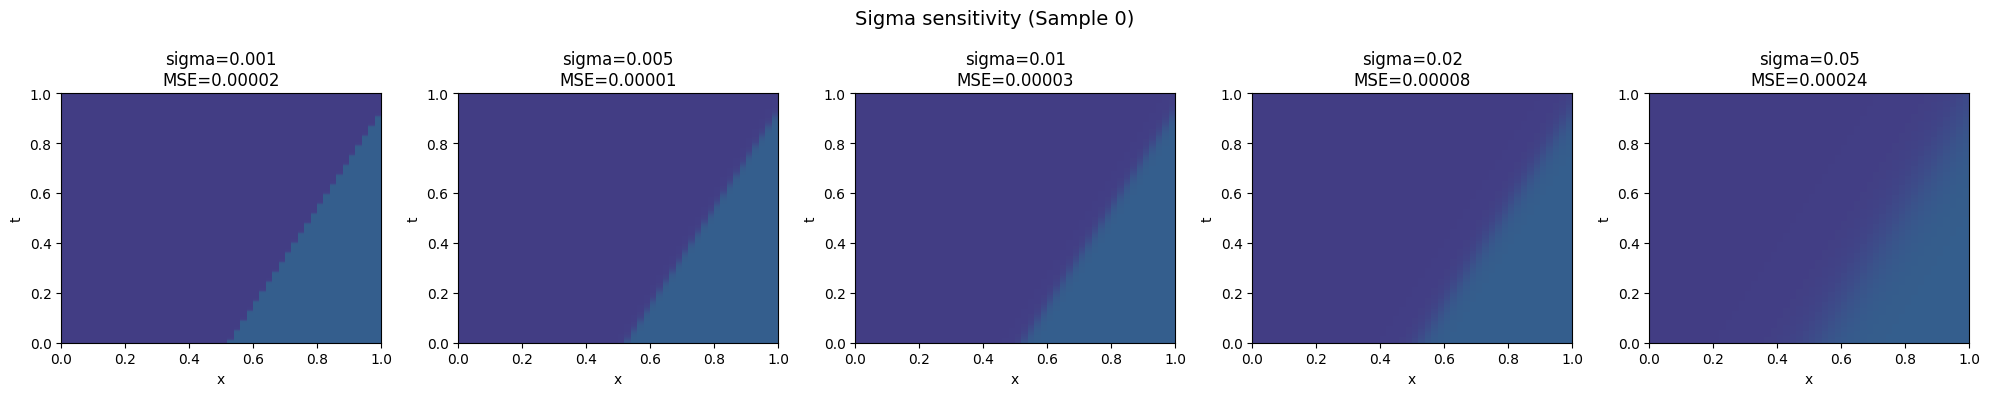

In [23]:
sigma_values = [0.001, 0.005, 0.01, 0.02, 0.05]

fig, axes = plt.subplots(1, len(sigma_values), figsize=(4 * len(sigma_values), 4))

with torch.no_grad():
    for ax, sigma in zip(axes, sigma_values):
        grid = model.get_grid(waves, batch_input["t_coords"], batch_input["x_coords"], sigma)
        pred_s = grid[s, 0].cpu().numpy()

        mse = float(np.mean((pred_s - gt) ** 2))
        ax.imshow(pred_s, extent=extent, aspect="auto", origin="lower", cmap="viridis", vmin=0, vmax=1)
        ax.set_title(f"sigma={sigma}\nMSE={mse:.5f}")
        ax.set_xlabel("x"); ax.set_ylabel("t")

plt.suptitle(f"Sigma sensitivity (Sample {s})", fontsize=14)
plt.tight_layout()
plt.show()

## 8. Resolution Generalization

Test the model on higher-resolution grids (same physical domain, finer discretization).

  steps=2: using 10 cached samples
  steps=3: using 10 cached samples
Created datasets: train=0, val=0, test=20


Testing: 100%|██████████| 5/5 [00:00<00:00, 27.19it/s]


2x Resolution (100x500)
  mse         : 0.004166
  mae         : 0.037504
  rel_l2      : 0.120902
  max_error   : 0.480378


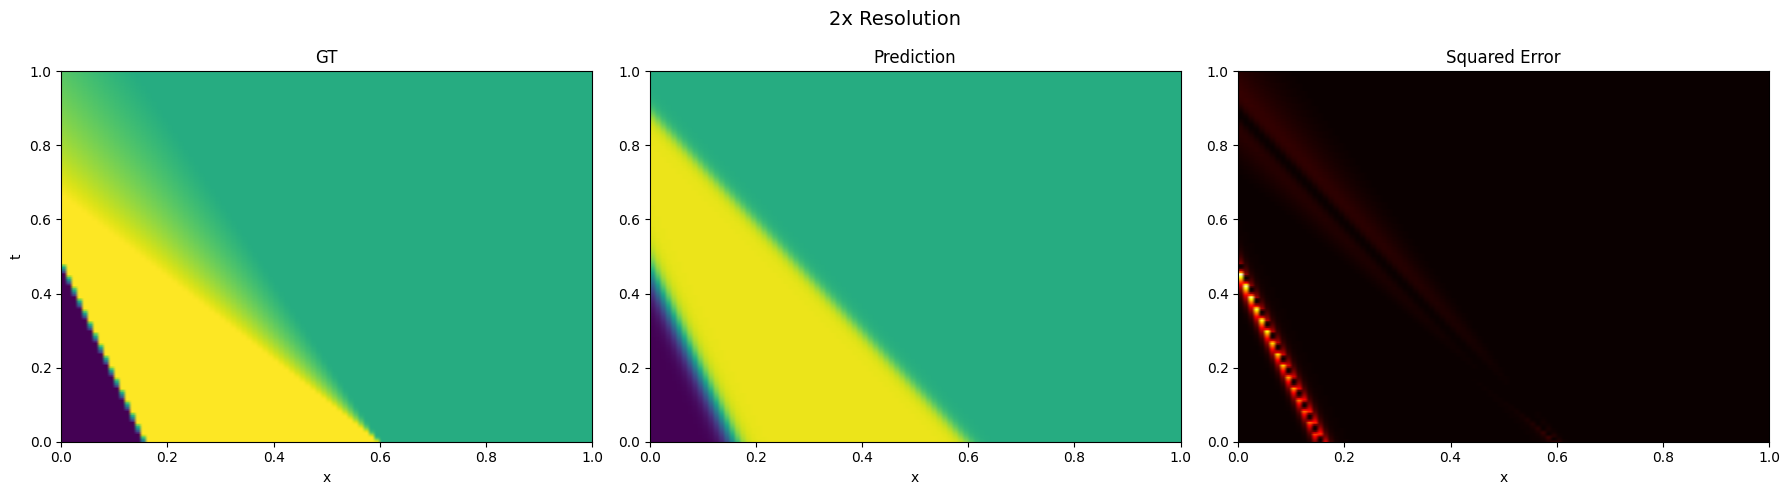

  steps=2: using 10 cached samples
  steps=3: using 10 cached samples
Created datasets: train=0, val=0, test=20


Testing: 100%|██████████| 5/5 [00:00<00:00, 10.72it/s]


3x Resolution (150x750)
  mse         : 0.004463
  mae         : 0.036801
  rel_l2      : 0.112656
  max_error   : 0.450742


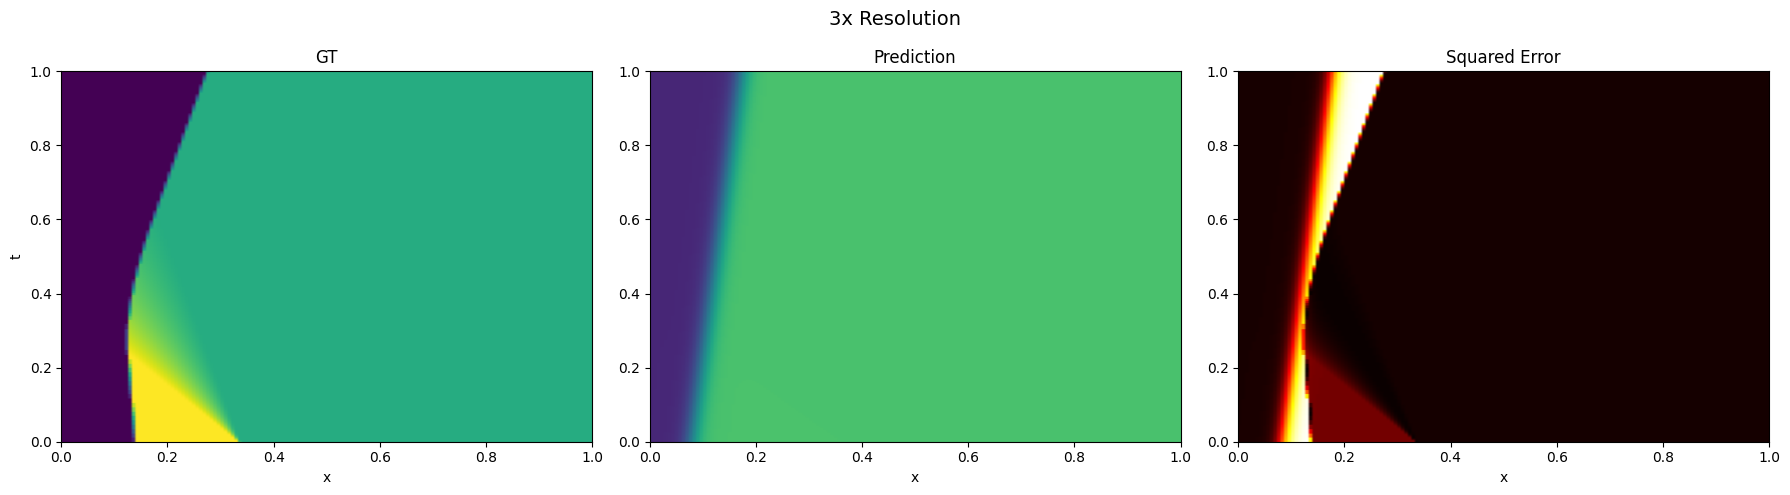

In [24]:
for res_mult in [2, 3]:
    hr_config = {
        "nx": grid_config["nx"] * res_mult,
        "nt": grid_config["nt"] * res_mult,
        "dx": grid_config["dx"] / res_mult,
        "dt": grid_config["dt"] / res_mult,
    }

    _, _, hr_ds = get_wavefront_datasets(
        n_samples=20,
        grid_config=hr_config,
        model_name="WaveFrontModel",
        train_ratio=0.0,
        val_ratio=0.0,
        max_steps=MAX_STEPS,
        only_shocks=ONLY_SHOCKS,
    )
    hr_loader = DataLoader(hr_ds, batch_size=4, shuffle=False, collate_fn=collate_wavefront_batch)

    hr_metrics, hr_samples = eval_model(model, hr_loader, device, grid_config=hr_config, num_plots=2)

    print(f"\n{res_mult}x Resolution ({hr_config['nx']}x{hr_config['nt']})")
    for k, v in hr_metrics.items():
        print(f"  {k:12s}: {v:.6f}")

    # Show one sample
    hr_extent = [0, hr_config["nx"] * hr_config["dx"], 0, hr_config["nt"] * hr_config["dt"]]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    gt_hr = hr_samples["grids"][0]
    pred_hr = hr_samples["output_grid"][0]
    err_hr = (pred_hr - gt_hr) ** 2

    vmin, vmax = min(gt_hr.min(), pred_hr.min()), max(gt_hr.max(), pred_hr.max())
    axes[0].imshow(gt_hr, extent=hr_extent, aspect="auto", origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
    axes[0].set_title("GT"); axes[0].set_xlabel("x"); axes[0].set_ylabel("t")
    axes[1].imshow(pred_hr, extent=hr_extent, aspect="auto", origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
    axes[1].set_title("Prediction"); axes[1].set_xlabel("x")
    axes[2].imshow(err_hr, extent=hr_extent, aspect="auto", origin="lower", cmap="hot")
    axes[2].set_title("Squared Error"); axes[2].set_xlabel("x")
    plt.suptitle(f"{res_mult}x Resolution", fontsize=14)
    plt.tight_layout()
    plt.show()